In [2]:
from datasets import load_dataset
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import requests, zipfile, io
import os
from transformers import pipeline

c:\Users\tobia\anaconda3\envs\chatbot-classification\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = load_dataset("deepset/germanquad", split="train")

#remove 50% of the question marks
questions = pd.DataFrame(data)[["question"]]
questions.columns = ["text"]

questions

,text
0,Von welchem Gesetzt stammt das Amerikanische ab?
1,Warum unterscheidet sich das amerikanische Rec...
2,Wie viele ethnische Gruppen und indigenen Völk...
3,Woher kommt die Sexuelle Orientierung von Mens...
4,Seit wann gehört Guam zu dem Gebiet der Verein...
...,...
11513,Welchem Staat wurde Eritrea nach dem Zweiten W...
11514,In welchem Jahr annektierte Haile Selassie Eri...
11515,Wie lange dauerte der Unabhängigkeitskampf in ...
11516,Wann endete der Kampf um die Unabhängigkeit Er...


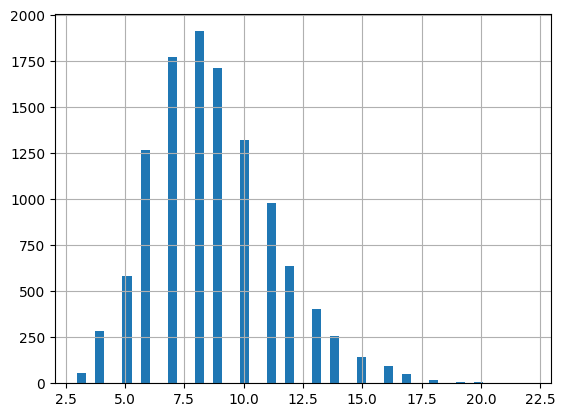

In [3]:
questions.text.apply(lambda x: len(x.split(" "))).hist(bins=50)
plt.show()

In [4]:
data = load_dataset("philschmid/germeval18", split="train")

germeval18 = pd.DataFrame(data)

match = re.compile(r'[^a-zA-Z\säßüö\"\'.!?]', flags=re.UNICODE)

def correction(text:str):
    """Removes username calling (@Username), only allows text, punktucation, double quote, single quote and replaces 'ß' with 'ss'
    """
    return match.sub(u'', str.join(" ", [word.replace("ß", "ss") for word in text.split(" ") if not str.startswith(word, "@")]))

['INSULT', 'PROFANITY', 'ABUSE']

offensive = germeval18[germeval18.binary == "OFFENSE"][["text"]]
offensive.columns = ["text"]

offensive

,text
4,@spdde kein verläßlicher Verhandlungspartner. ...
6,@milenahanm 33 bis 45 habe ich noch gar nicht ...
8,@tagesschau Euere AfD Hetze wirkt. Da könnt ih...
9,"Deutsche Medien, Halbwahrheiten und einseitige..."
11,@Ralf_Stegner Oman Ralle..dich mag ja immer no...
...,...
4993,@IM_NRW @FfFrauki Diese absolute Unfähigkeit ....
4994,Das Deutsche Kaiserreich soll wieder auferstehen
5005,"@GlasenappHenrik Zu Merkel fällt mir nur ein, ..."
5006,@KokoLores20 @krippmarie Ein richtiges Zeichen...


In [5]:
offensive["text"] = offensive.text.apply(correction)

offensive

,text
4,kein verlässlicher Verhandlungspartner. Nachka...
6,bis habe ich noch gar nicht gelebt und es ge...
8,Euere AfD Hetze wirkt. Da könnt ihr stolz sein...
9,Deutsche Medien Halbwahrheiten und einseitige ...
11,Oman Ralle..dich mag ja immer noch keiner. Du ...
...,...
4993,Diese absolute Unfähigkeit ...schleicht sich d...
4994,Das Deutsche Kaiserreich soll wieder auferstehen
5005,Zu Merkel fällt mir nur ein ein Mal Verräterin...
5006,Ein richtiges Zeichen unserer Nachbarn...schle...


<Axes: >

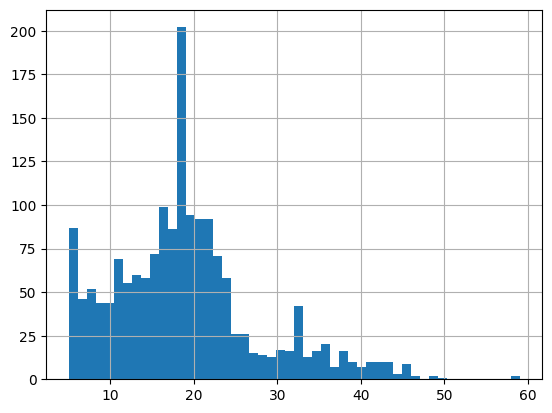

In [6]:
offensive.text.apply(lambda x: len(x.split(" "))).hist(bins=50)

<Axes: >

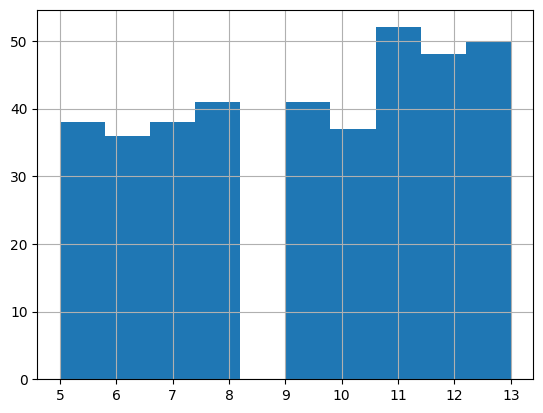

<Axes: >

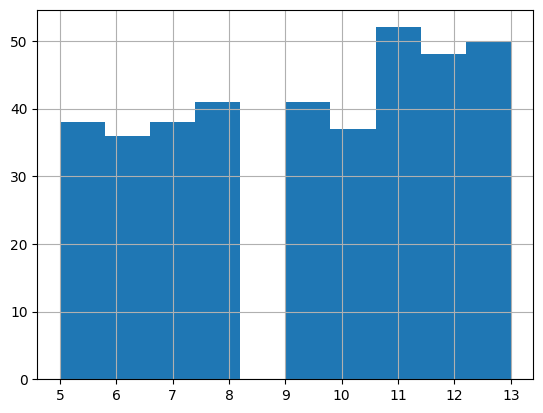

<Axes: >

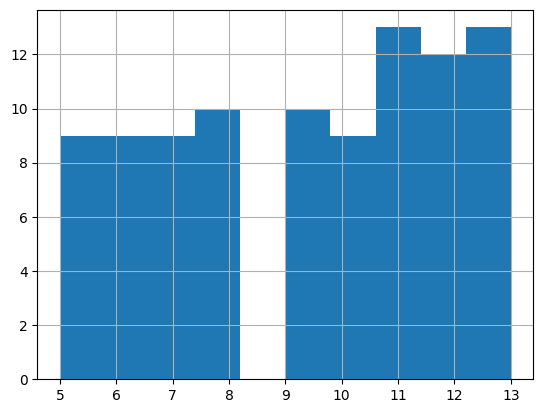

<Axes: >

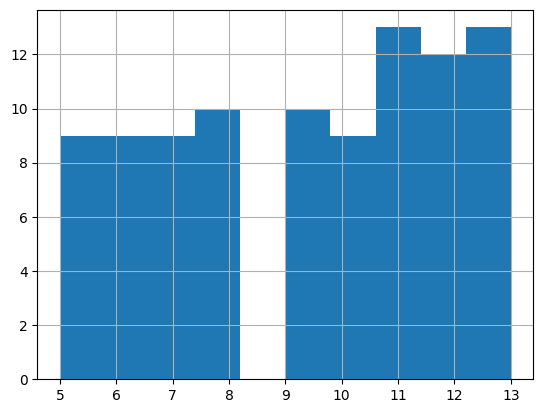

In [22]:
def sampler(df1:pd.DataFrame, df2:pd.DataFrame, min_max_bins:tuple, train_split:float=0.8):
    """Align distribution of word count per sample between df1 and df2 by random sampling. Additionally do a train test split by intervall.
    Args:
        df1 (pd.DataFrame): first dataframe
        df2 (pd.DataFrame): second dataframe
        min_max_bins (tuple): min token count, max token count, bin_size
        train_amount (float): train size
    
    Returns:
        (resampled train split from df1, resampled train split from df2, resampled test split from df1, resampled test split from df2) 
    """

    bins = pd.interval_range(start=min_max_bins[0], end=min_max_bins[1], freq=None, periods=min_max_bins[2], closed='right')

    df1_interals = pd.cut(df1.text.apply(lambda x: len(x.split())), bins)
    df2_interals = pd.cut(df2.text.apply(lambda x: len(x.split())), bins)

    # Align counts Series
    aligned1, aligned2 = df1_interals.value_counts().align(df2_interals.value_counts(), fill_value=0)

    # Combine and choose smallest value
    result = aligned1.combine(aligned2, func=lambda x, y: min(x, y))

    # Remove intervals which only appear in one series
    result = result[result != 0]

    #create groups
    df1_grouped = df1.groupby(df1_interals, observed=False)
    df2_grouped = df2.groupby(df2_interals, observed=False)

    #sampled dataframes stored here
    df1_sampled_train = []
    df2_sampled_train = []
    df1_sampled_test = []
    df2_sampled_test = []

    #iterate over intervals and random sample text with certain length
    for group, count in result.items():
        
        #random sample amount of 'count' from original
        df1_sampled = df1_grouped.get_group(group).sample(count, ignore_index=True)
        df2_sampled = df2_grouped.get_group(group).sample(count, ignore_index=True)

        #get training split
        df1_train = df1_sampled.sample(frac=train_split)
        df2_train = df2_sampled.sample(frac=train_split)

        #get test split
        df1_test = df1_sampled.drop(df1_train.index)
        df2_test = df2_sampled.drop(df2_train.index)

        df1_sampled_train.append(df1_train)
        df2_sampled_train.append(df2_train)
        df1_sampled_test.append(df1_test)
        df2_sampled_test.append(df2_test)
        
        
    #return concatted
    return pd.concat(df1_sampled_train, ignore_index=True), pd.concat(df2_sampled_train, ignore_index=True), pd.concat(df1_sampled_test, ignore_index=True), pd.concat(df2_sampled_test, ignore_index=True)

sampled_df1_train, sampled_df2_train, sampled_df1_test, sampled_df2_test = sampler(questions, offensive, (3, 13, 10))

display(sampled_df1_train.text.apply(lambda x: len(x.split())).hist(bins=10))
plt.show()
display(sampled_df2_train.text.apply(lambda x: len(x.split())).hist(bins=10))
plt.show()
display(sampled_df1_test.text.apply(lambda x: len(x.split())).hist(bins=10))
plt.show()
display(sampled_df2_test.text.apply(lambda x: len(x.split())).hist(bins=10))
plt.show()

In [3]:
#SAD dataset (https://github.com/PervasiveWellbeingTech/Stress-Annotated-Dataset-SAD)
r = requests.get("https://raw.githubusercontent.com/PervasiveWellbeingTech/Stress-Annotated-Dataset-SAD/main/SAD_v1.zip")
z = zipfile.ZipFile(io.BytesIO(r.content))

filename = z.extract("SAD_v1.xlsx")

df = pd.read_excel(filename)

os.remove(filename)

In [7]:
df

,sID,sentence,is_stressor,is_stressor_conf,is_covid,is_covid_conf,original_label,top_label,second_label,avg_severity,...,Other,Everyday Decision Making,Emotional Turmoil,School,Family Issues,Social Relationships,Work,"Health, Fatigue, or Physical Pain",Source,is_seed
0,0,?,0,1.0,0,1.0,Other,Other,,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,popbots_live,0
1,1,2 of my foster kittens died,1,1.0,0,1.0,Other,Emotional Turmoil,Other,8.2,...,0.1,0.0,0.9,0.0,0.0,0.0,0.0,0.0,popbots_live,1
2,2,A better question would be what is not stressi...,1,1.0,0,0.8,Work,Everyday Decision Making,Other,5.4,...,0.3,0.6,0.1,0.0,0.0,0.0,0.0,0.0,mTurk_synthetic_covid,0
3,3,a big project at work.,0,0.6,0,1.0,Work,Other,Work,2.2,...,0.6,0.0,0.0,0.0,0.0,0.0,0.4,0.0,mTurk_synthetic,0
4,4,a certain person at work is being really angry...,1,1.0,0,1.0,Emotional Turmoil,Work,Social Relationships,3.4,...,0.0,0.0,0.0,0.0,0.0,0.3,0.7,0.0,mTurk_synthetic,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6845,6845,"I will not be attending school tomorrow, im no...",1,1.0,0,1.0,Family Issues,School,Emotional Turmoil,3.6,...,0.0,0.0,0.1,0.9,0.0,0.0,0.0,0.0,Inquire,0
6846,6846,"It's not fair to me, her, or my husband and ch...",1,1.0,0,1.0,Family Issues,Family Issues,Social Relationships,4.8,...,0.1,0.0,0.1,0.0,0.6,0.2,0.0,0.0,Inquire,0
6847,6847,God knows my mom and dad don't want me.,1,1.0,0,1.0,Family Issues,Family Issues,Emotional Turmoil,6.0,...,0.0,0.0,0.2,0.0,0.7,0.1,0.0,0.0,Inquire,0
6848,6848,Got into another fight with my brother.,1,1.0,0,1.0,Family Issues,Family Issues,Social Relationships,3.6,...,0.0,0.0,0.1,0.0,0.8,0.1,0.0,0.0,Inquire,0


In [19]:
concern = df[df.top_label == "School"][["sentence"]].reset_index(drop=True, inplace=False)
concern.columns = ["text"]

In [20]:
concern

,text
21,a paper i need to write
27,a professor is driving me crazy.
38,Adjusting to distance learning for graduate le...
41,All of my classes being online and my roommate...
42,All of my classes moving online
...,...
6558,"i have to worry about college, and school sta..."
6716,"Because of all my emotional burdens, I have be..."
6751,I'm scared I'm not going to be able to handle ...
6800,"I can't make it through school, I cause my fam..."


In [ ]:
text_En2De = pipeline('translation', model='Tanhim/translation-En2De', tokenizer='Tanhim/translation-En2De', device="cuda:0")

concern["text"] = 

In [25]:
text_En2De(concern.text.to_list())

c:\Users\tobia\anaconda3\envs\chatbot-classification\Lib\site-packages\transformers\pipelines\base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


[{'translation_text': 'ein Papier, das ich schreiben muss'},
 {'translation_text': 'Ein Professor macht mich verrückt.'},
 {'translation_text': 'Anpassung an den Fernunterricht für Studiengänge auf Hochschulniveau'},
 {'translation_text': 'Alle meine Kurse sind online und meine Mitbewohner sind heuchlerisch.'},
 {'translation_text': 'Alle meine Kurse bewegen sich online'},
 {'translation_text': 'all diese Prüfungen habe ich kommen und keine Zeit zu studieren!'},
 {'translation_text': 'All diese Schularbeiten'},
 {'translation_text': 'All diese Schularbeiten, die ich in letzter Zeit hatte.'},
 {'translation_text': 'Eine Prüfung in der Schule, die jeder sagt, dass man nicht bestehen kann.'},
 {'translation_text': 'Da ich mich auf Pflegeschulen bewerbe, gibt es so viele Bewerber, die ich hoffe, ich komme in.'},
 {'translation_text': 'Wegen eines Stromausfalls wurden alle meine Kurse ins Internet verschoben.'},
 {'translation_text': 'big test coming up and need to complete my work.'},
 {'t

In [22]:
text_En2De(["Sentence 1", "Sentence 2"])

c:\Users\tobia\anaconda3\envs\chatbot-classification\Lib\site-packages\transformers\pipelines\base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


[{'translation_text': 'Satz 1'}, {'translation_text': 'Satz 2'}]